# **Cycling analysis**

---

## **Imports**

In [37]:
import requests
from bs4 import BeautifulSoup
import os
import re
from urllib.parse import urljoin
import selenium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
%matplotlib inline

---

## **Import csv files**

### **Inspect differences between CSV files**

In [38]:
# Define data folder
data_folder = "data/tfl_cycling_data"

# Get all CSV files
csv_files = sorted([f for f in os.listdir(data_folder) if f.endswith(".csv")])

# Dictionary to store column names for each file
column_map = {}

# Extract column names from each CSV file
for file in csv_files:
    df = pd.read_csv(os.path.join(data_folder, file), nrows=1)  # Read only first row for efficiency
    column_map[file] = set(df.columns)

# Find unique sets of column names
unique_column_sets = {}
for file, columns in column_map.items():
    columns_tuple = tuple(sorted(columns))  # Convert to tuple for dict keys (hashable)
    if columns_tuple not in unique_column_sets:
        unique_column_sets[columns_tuple] = []
    unique_column_sets[columns_tuple].append(file)

# Print summary of differences
for idx, (columns, files) in enumerate(unique_column_sets.items()):
    print(f"🔹 **Column Set {idx+1}: Found in {len(files)} files**")
    print(f"Files: {files[:5]}{'...' if len(files) > 5 else ''}")  # Show first few files
    print(f"Columns: {columns}\n")

🔹 **Column Set 1: Found in 89 files**
Files: ['246JourneyDataExtract23Dec2020-29Dec2020.csv', '246JourneyDataExtract30Dec2020-05Jan2021.csv', '247JourneyDataExtract06Jan2021-12Jan2021.csv', '248JourneyDataExtract13Jan2021-19Jan2021.csv', '249JourneyDataExtract20Jan2021-26Jan2021.csv']...
Columns: ('Bike Id', 'Duration', 'End Date', 'EndStation Id', 'EndStation Name', 'Rental Id', 'Start Date', 'StartStation Id', 'StartStation Name')

🔹 **Column Set 2: Found in 1 files**
Files: ['325JourneyDataExtract06Jul2022-12Jul2022.csv']
Columns: ('Bike Id', 'Duration', 'End Date', 'EndStation Name', 'Rental Id', 'Start Date', 'StartStation Id', 'StartStation Name')

🔹 **Column Set 3: Found in 53 files**
Files: ['335JourneyDataExtract12Sep2022-18Sep2022.csv', '336JourneyDataExtract19Sep2022-25Sep2022.csv', '337JourneyDataExtract26Sep2022-02Oct2022.csv', '338JourneyDataExtract03Oct2022-09Oct2022.csv', '339JourneyDataExtract10Oct2022-16Oct2022.csv']...
Columns: ('Bike model', 'Bike number', 'End date

### **Group similar files**

In [39]:
file_groups = {}

for idx, (columns, files) in enumerate(unique_column_sets.items()):
    var_name = f"group_{idx+1}"
    file_groups[var_name] =  files

# Access groups
group_1 = file_groups.get("group_1", [])
group_2 = file_groups.get("group_2", [])
group_3 = file_groups.get("group_3", [])

# Print to verify
print("Group 1 files:", group_1[:5])
print("Group 2 files:", group_2[:5])
print("Group 3 files:", group_3[:5])

Group 1 files: ['246JourneyDataExtract23Dec2020-29Dec2020.csv', '246JourneyDataExtract30Dec2020-05Jan2021.csv', '247JourneyDataExtract06Jan2021-12Jan2021.csv', '248JourneyDataExtract13Jan2021-19Jan2021.csv', '249JourneyDataExtract20Jan2021-26Jan2021.csv']
Group 2 files: ['325JourneyDataExtract06Jul2022-12Jul2022.csv']
Group 3 files: ['335JourneyDataExtract12Sep2022-18Sep2022.csv', '336JourneyDataExtract19Sep2022-25Sep2022.csv', '337JourneyDataExtract26Sep2022-02Oct2022.csv', '338JourneyDataExtract03Oct2022-09Oct2022.csv', '339JourneyDataExtract10Oct2022-16Oct2022.csv']


### **Separate unique files into separate Data Frames**

In [40]:
data_folder = "data/tfl_cycling_data"

df1_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_1]
df1 =  pd.concat(df1_batch, ignore_index=True)

df2_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_2]
df2 =  pd.concat(df2_batch, ignore_index=True)

df3_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_3]
df3 =  pd.concat(df3_batch, ignore_index=True)

/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_71444/993685103.py:9: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df3_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_3]
/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_71444/993685103.py:9: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df3_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_3]
/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_71444/993685103.py:9: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df3_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_3]


---

## **Rename columns**

#### **Comparison**  
- "Rental Id" -> "Number";  
- "Duration" (seconds) -> "Total duration (ms)" -------> delete column "Total duration";  
- "Bike Id" -> "Bike number";  
- "End Date" -> "End date";  
- "EndStation Id" -> "End station number";  
- "EndStation Name" -> "End station";  
- "Start Date" -> "Start date";  
- "StartStation Id" -> "Start station number";  
- "StartStation Name" -> "Start station";  

Only in second dataset:  
- "Bike model"
- "Total duration"

In [41]:
list(df1.columns)

['Rental Id',
 'Duration',
 'Bike Id',
 'End Date',
 'EndStation Id',
 'EndStation Name',
 'Start Date',
 'StartStation Id',
 'StartStation Name']

In [42]:
new_col_names_df1 = {
    'Rental Id': "rental_id",
    'Duration': "duration",
    'Bike Id': "bike_id",
    'End Date': "end_date",
    'EndStation Id': "end_station_id",
    'EndStation Name' :"end_station_name",
    'Start Date': "start_date",
    'StartStation Id': "start_station_id",
    'StartStation Name': "start_station_name"
}

In [43]:
df1 = df1.rename(columns=new_col_names_df1)
df1.head()

,rental_id,duration,bike_id,end_date,end_station_id,end_station_name,start_date,start_station_id,start_station_name
0,104666386,5100,17552,24/12/2020 18:19,107,"Finsbury Leisure Centre, St. Luke's",24/12/2020 16:54,30,"Windsor Terrace, Hoxton"
1,104708347,2400,12134,27/12/2020 14:37,194,"Hop Exchange, The Borough",27/12/2020 13:57,298,"Curlew Street, Shad Thames"
2,104664061,300,18429,24/12/2020 15:23,91,"Walnut Tree Walk, Vauxhall",24/12/2020 15:18,272,"Baylis Road, Waterloo"
3,104723992,1440,17175,28/12/2020 13:30,742,"Blenheim Crescent, Ladbroke Grove",28/12/2020 13:06,303,"Albert Gate, Hyde Park"
4,104721666,840,15313,28/12/2020 11:23,307,"Black Lion Gate, Kensington Gardens",28/12/2020 11:09,742,"Blenheim Crescent, Ladbroke Grove"


In [53]:
# Convert 'start_date' and 'end_date' to datetime
df1['start_date'] = pd.to_datetime(df1['start_date'], errors='coerce')
df1['end_date'] = pd.to_datetime(df1['end_date'], errors='coerce')

# Convert to a different format (e.g., 'DD/MM/YYYY HH:MM')
# df1['start_date'] = df1['start_date'].dt.strftime('%d/%m/%Y %H:%M')
# df1['end_date'] = df1['end_date'].dt.strftime('%d/%m/%Y %H:%M')

/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_71444/1734388408.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1['start_date'] = pd.to_datetime(df1['start_date'], errors='coerce')
/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_71444/1734388408.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1['end_date'] = pd.to_datetime(df1['end_date'], errors='coerce')


In [54]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19517751 entries, 0 to 19517750
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rental_id           int64         
 1   duration            int64         
 2   bike_id             int64         
 3   end_date            datetime64[ns]
 4   end_station_id      int64         
 5   end_station_name    object        
 6   start_date          datetime64[ns]
 7   start_station_id    int64         
 8   start_station_name  object        
dtypes: datetime64[ns](2), int64(5), object(2)
memory usage: 1.3+ GB


In [46]:
list(df2.columns)

['Rental Id',
 'Duration',
 'Bike Id',
 'End Date',
 'EndStation Name',
 'Start Date',
 'StartStation Id',
 'StartStation Name']

In [47]:
# does not have EndStation Id

new_col_names_df2 = {
    'Rental Id': "rental_id",
    'Duration': "duration",
    'Bike Id': "bike_id",
    'End Date': "end_date",
    'EndStation Name' :"end_station_name",
    'Start Date': "start_date",
    'StartStation Id': "start_station_id",
    'StartStation Name': "start_station_name"
}

In [48]:
df2 = df2.rename(columns=new_col_names_df2)
df2.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_id,start_station_name
0,122342973,180,16835,06/07/2022 15:26,"St. Mary & St. Michael Church, Stepney",06/07/2022 15:23,500,"Ansell House, Stepney"
1,122443043,1380,8260,08/07/2022 18:09,"Belgrove Street , King's Cross",08/07/2022 17:46,297,"Geraldine Street, Elephant & Castle"
2,122392666,600,17431,07/07/2022 17:00,"Eel Brook Common, Walham Green",07/07/2022 16:50,615,"Finlay Street, Fulham"
3,122516692,900,39,10/07/2022 11:47,"Drury Lane, Covent Garden",10/07/2022 11:32,310,"Black Prince Road, Vauxhall"
4,122561553,1140,6484,11/07/2022 09:55,"Duke Street Hill, London Bridge",11/07/2022 09:36,310,"Black Prince Road, Vauxhall"


In [51]:
# Convert 'start_date' and 'end_date' to datetime
df2['start_date'] = pd.to_datetime(df2['start_date'], errors='coerce')
df2['end_date'] = pd.to_datetime(df2['end_date'], errors='coerce')

# # Convert to a different format (e.g., 'DD/MM/YYYY HH:MM')
# df2['start_date'] = df2['start_date'].dt.strftime('%d/%m/%Y %H:%M')
# df2['end_date'] = df2['end_date'].dt.strftime('%d/%m/%Y %H:%M')

In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312144 entries, 0 to 312143
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   rental_id           312144 non-null  int64         
 1   duration            312144 non-null  int64         
 2   bike_id             312144 non-null  int64         
 3   end_date            312144 non-null  datetime64[ns]
 4   end_station_name    312144 non-null  object        
 5   start_date          312144 non-null  datetime64[ns]
 6   start_station_id    312144 non-null  int64         
 7   start_station_name  312144 non-null  object        
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 19.1+ MB


In [57]:
list(df3.columns)

['Number',
 'Start date',
 'Start station number',
 'Start station',
 'End date',
 'End station number',
 'End station',
 'Bike number',
 'Bike model',
 'Total duration',
 'Total duration (ms)']

In [58]:
df3['duration'] = df3['Total duration (ms)'] / 1000
df3.duration.head()

0    7934.133
1     736.233
2     929.662
3    1411.818
4    1400.619
Name: duration, dtype: float64

In [59]:
new_col_names_df3 = {
    'Number': "rental_id",
    'duration': "duration",
    'Bike number': "bike_id",
    'End date': "end_date",
    'End station number': "end_station_id",
    'End station' :"end_station_name",
    'Start date': "start_date",
    'Start station number': "start_station_id",
    'Start station': "start_station_name",
    "Bike model": "model",
    'Total duration': "total_duration",
    'Total duration (ms)': "total_duration_ms"
}

In [60]:
df3 = df3.rename(columns=new_col_names_df3)
df3.head()

,rental_id,start_date,start_station_id,start_station_name,end_date,end_station_id,end_station_name,bike_id,model,total_duration,total_duration_ms,duration
0,125230172,2022-09-18 23:59,001059,"Albert Embankment, Vauxhall",2022-09-19 02:11,200222,"Danvers Street, West Chelsea",54170,CLASSIC,2h 12m 14s,7934133,7934.133
1,125230173,2022-09-18 23:59,002660,"Frith Street, Soho",2022-09-19 00:11,001194,"Westminster University, Marylebone",50087,CLASSIC,12m 16s,736233,736.233
2,125230174,2022-09-18 23:59,001183,"Bramham Gardens, Earl's Court",2022-09-19 00:14,300019,"Felsham Road, Putney",54561,CLASSIC,15m 29s,929662,929.662
3,125230175,2022-09-18 23:59,010624,"Strata, Elephant & Castle",2022-09-19 00:23,300252,"Canada Water Station, Rotherhithe",54324,CLASSIC,23m 31s,1411818,1411.818
4,125230176,2022-09-18 23:59,010624,"Strata, Elephant & Castle",2022-09-19 00:23,300252,"Canada Water Station, Rotherhithe",22065,CLASSIC,23m 20s,1400619,1400.619


In [63]:
# Convert 'start_date' and 'end_date' to datetime
df3['start_date'] = pd.to_datetime(df3['start_date'], errors='coerce')
df3['end_date'] = pd.to_datetime(df3['end_date'], errors='coerce')

/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_71444/1755227281.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df3['start_date'] = pd.to_datetime(df3['start_date'], errors='coerce')
/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_71444/1755227281.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df3['end_date'] = pd.to_datetime(df3['end_date'], errors='coerce')


In [64]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11059475 entries, 0 to 11059474
Data columns (total 12 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rental_id           int64         
 1   start_date          datetime64[ns]
 2   start_station_id    object        
 3   start_station_name  object        
 4   end_date            datetime64[ns]
 5   end_station_id      object        
 6   end_station_name    object        
 7   bike_id             int64         
 8   model               object        
 9   total_duration      object        
 10  total_duration_ms   int64         
 11  duration            float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 1012.5+ MB


---

### **Drop columns + store Data Frame with bike model for later use**

In [65]:
df_with_model = df3.drop(columns=["total_duration_ms", "total_duration"], axis=1)

In [66]:
df_with_model.model.value_counts(normalize=True)

model
CLASSIC       0.932367
PBSC_EBIKE    0.067633
Name: proportion, dtype: float64

In [67]:
# df3 excluding model feature
df3 = df_with_model.drop(columns=["model"], axis=1)

---

## **Drop ID columns as they are inconsistent in df3**

In [68]:
# drop start_station_id
# drop end_station_id
# create new start_station_id based on start_station_name
# create new end_station_id based on end_station_name

df1 = df1.drop(columns=["start_station_id", "end_station_id"], axis=1)
df2 = df2.drop(columns=["start_station_id"], axis=1) # df2 never had an end_station_id to begin with
df3 = df3.drop(columns=["start_station_id", "end_station_id"], axis=1)

In [69]:
# Check columns are consistent
print(sorted(df1.columns) == sorted(df2.columns))
print(sorted(df1.columns) == sorted(df3.columns))

True
True


---

## **Concatenate Data Frames**

In [70]:
# Match df2 and df3 to the column order of df1
df2 = df2[df1.columns]
df3 =  df3[df1.columns]

# Concatenate data frames
df_combined = pd.concat([df1,df2,df3], ignore_index=True)
df_combined.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_name
0,104666386,5100.0,17552,2020-12-24 18:19:00,"Finsbury Leisure Centre, St. Luke's",2020-12-24 16:54:00,"Windsor Terrace, Hoxton"
1,104708347,2400.0,12134,2020-12-27 14:37:00,"Hop Exchange, The Borough",2020-12-27 13:57:00,"Curlew Street, Shad Thames"
2,104664061,300.0,18429,2020-12-24 15:23:00,"Walnut Tree Walk, Vauxhall",2020-12-24 15:18:00,"Baylis Road, Waterloo"
3,104723992,1440.0,17175,2020-12-28 13:30:00,"Blenheim Crescent, Ladbroke Grove",2020-12-28 13:06:00,"Albert Gate, Hyde Park"
4,104721666,840.0,15313,2020-12-28 11:23:00,"Black Lion Gate, Kensington Gardens",2020-12-28 11:09:00,"Blenheim Crescent, Ladbroke Grove"


---

## **Create new IDs**

In [71]:
# Find unique list of all station names
all_station_names = pd.concat([df_combined['start_station_name'], df_combined['end_station_name']]).unique()

# Map the stations
station_mapping = {name: idx for idx, name in enumerate(all_station_names, start=1)}

# Map the station names to their corresponding IDs
df_combined['start_station_id'] = df_combined['start_station_name'].map(station_mapping)
df_combined['end_station_id'] = df_combined['end_station_name'].map(station_mapping)

print(df_combined.head())

# Check for missing values in new IDs
print(df_combined[['start_station_id', 'end_station_id']].isnull().sum())

   rental_id  duration  bike_id            end_date  \
0  104666386    5100.0    17552 2020-12-24 18:19:00   
1  104708347    2400.0    12134 2020-12-27 14:37:00   
2  104664061     300.0    18429 2020-12-24 15:23:00   
3  104723992    1440.0    17175 2020-12-28 13:30:00   
4  104721666     840.0    15313 2020-12-28 11:23:00   

                      end_station_name          start_date  \
0  Finsbury Leisure Centre, St. Luke's 2020-12-24 16:54:00   
1            Hop Exchange, The Borough 2020-12-27 13:57:00   
2           Walnut Tree Walk, Vauxhall 2020-12-24 15:18:00   
3    Blenheim Crescent, Ladbroke Grove 2020-12-28 13:06:00   
4  Black Lion Gate, Kensington Gardens 2020-12-28 11:09:00   

                  start_station_name  start_station_id  end_station_id  
0            Windsor Terrace, Hoxton                 1             397  
1         Curlew Street, Shad Thames                 2             306  
2              Baylis Road, Waterloo                 3             372  
3   

In [72]:
df_combined.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_name,start_station_id,end_station_id
0,104666386,5100.0,17552,2020-12-24 18:19:00,"Finsbury Leisure Centre, St. Luke's",2020-12-24 16:54:00,"Windsor Terrace, Hoxton",1,397
1,104708347,2400.0,12134,2020-12-27 14:37:00,"Hop Exchange, The Borough",2020-12-27 13:57:00,"Curlew Street, Shad Thames",2,306
2,104664061,300.0,18429,2020-12-24 15:23:00,"Walnut Tree Walk, Vauxhall",2020-12-24 15:18:00,"Baylis Road, Waterloo",3,372
3,104723992,1440.0,17175,2020-12-28 13:30:00,"Blenheim Crescent, Ladbroke Grove",2020-12-28 13:06:00,"Albert Gate, Hyde Park",4,5
4,104721666,840.0,15313,2020-12-28 11:23:00,"Black Lion Gate, Kensington Gardens",2020-12-28 11:09:00,"Blenheim Crescent, Ladbroke Grove",5,435


---

## **EDA**

In [74]:
df_combined.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_name,start_station_id,end_station_id
0,104666386,5100.0,17552,2020-12-24 18:19:00,"Finsbury Leisure Centre, St. Luke's",2020-12-24 16:54:00,"Windsor Terrace, Hoxton",1,397
1,104708347,2400.0,12134,2020-12-27 14:37:00,"Hop Exchange, The Borough",2020-12-27 13:57:00,"Curlew Street, Shad Thames",2,306
2,104664061,300.0,18429,2020-12-24 15:23:00,"Walnut Tree Walk, Vauxhall",2020-12-24 15:18:00,"Baylis Road, Waterloo",3,372
3,104723992,1440.0,17175,2020-12-28 13:30:00,"Blenheim Crescent, Ladbroke Grove",2020-12-28 13:06:00,"Albert Gate, Hyde Park",4,5
4,104721666,840.0,15313,2020-12-28 11:23:00,"Black Lion Gate, Kensington Gardens",2020-12-28 11:09:00,"Blenheim Crescent, Ladbroke Grove",5,435


In [73]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30889370 entries, 0 to 30889369
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rental_id           int64         
 1   duration            float64       
 2   bike_id             int64         
 3   end_date            datetime64[ns]
 4   end_station_name    object        
 5   start_date          datetime64[ns]
 6   start_station_name  object        
 7   start_station_id    int64         
 8   end_station_id      int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(2)
memory usage: 2.1+ GB


In [75]:
# check for missing values
df_combined.isnull().sum()

rental_id             0
duration              0
bike_id               0
end_date              0
end_station_name      0
start_date            0
start_station_name    0
start_station_id      0
end_station_id        0
dtype: int64

In [76]:
# drop duplicates
df_combined.drop_duplicates(inplace=True)

<Axes: title={'center': 'Daily Rental Trends'}, xlabel='start_date'>

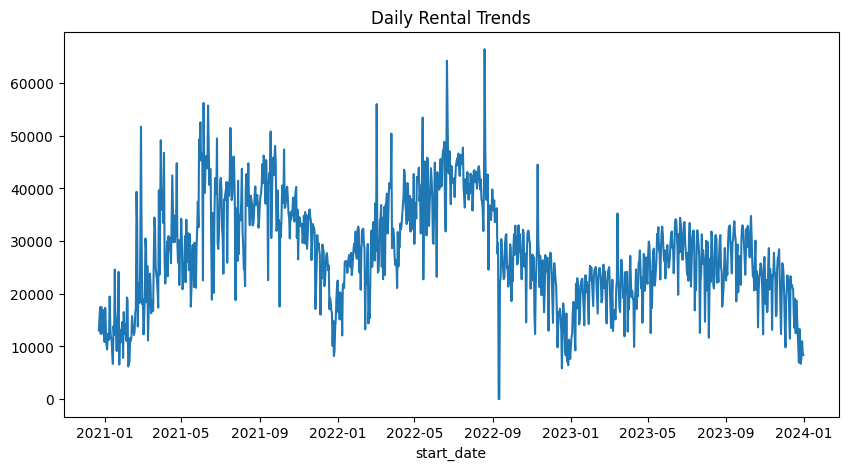

In [78]:
df_combined['start_date'].dt.date.value_counts().sort_index().plot(
    kind='line', figsize=(10,5), title="Daily Rental Trends")